# Config

In [ ]:
!pip install accelerate
!pip install git+https://github.com/huggingface/diffusers
!pip install git+https://github.com/huggingface/transformers
!pip install git+https://github.com/huggingface/huggingface_hub

# RESTART YOUR NOTEBOOK RN, the cell above this only takes effect after one restarts the cells

In [1]:
import os

In [2]:
##### file system
INPUT_DIR = "/kaggle/input/audio-mnist/data"
WORKING_DIR = "/kaggle/working"
SPECTROGRAM_DIR = WORKING_DIR + "/spectrograms"

##### dataset
SAMPLE_RATE = 48_000
MAX_INPUT_SIZE = 65_536

##### training
TRAIN_PERCENTAGE = 0.8
BATCH_SIZE = 4
DATA_PERCENTAGE = 0.5

##### notebook
EXPLORING = False

In [3]:
if not os.path.exists(WORKING_DIR):
    os.mkdir(WORKING_DIR)

# Explore Data

In [4]:
from tqdm import tqdm
from scipy.io import wavfile
import shutil
import matplotlib.pyplot as plt
import pandas as pd

# Create Spectrograms

In [5]:
import torchaudio

In [6]:
def create_spectrograms(input_size=int(MAX_INPUT_SIZE/2)):
    """
    Create Mel spectrograms from audio files in the INPUT_DIR directory and save them to the SPECTROGRAM_DIR directory.

    Args:
        input_size: The desired length of the audio files (in number of samples). Default value is MAX_INPUT_SIZE/2.

    Returns:
        None
    """

    # Iterate over all folders in INPUT_DIR
    for folder in tqdm(os.listdir(INPUT_DIR)):
        # check if "folder" is a folder
        if not os.path.isdir(os.path.join(INPUT_DIR, folder)):
            continue
        # Iterate over all files in the folder
        for file in os.listdir(os.path.join(INPUT_DIR, folder)):
            file_path = os.path.join(INPUT_DIR, folder, file)
            # Skip files that are not WAV files
            if not file_path.endswith('.wav'):
                continue

            # Load the audio file
            sample_rate, samples = wavfile.read(file_path)

            # Pad the audio file if it's smaller than input_size
            if samples.shape[0] < input_size:
                # Calculate the amount of padding needed
                pad_size = input_size - samples.shape[0]
                # Divide the padding equally between the left and right sides of the audio file
                left_pad = pad_size // 2
                right_pad = pad_size - left_pad
                # Pad the audio file with zeros
                samples = np.pad(samples, (left_pad, right_pad), mode='constant')

            # Crop the audio file at the center if it's larger than input_size
            elif samples.shape[0] > input_size:
                # Calculate the start and end positions for the crop
                start = (samples.shape[0] - input_size) // 2
                end = start + input_size
                # Crop the audio file
                samples = samples[start:end]

            # Convert the audio file to a float tensor
            samples = torch.from_numpy(samples).float()
                
            # Create the spectrogram using MelSpectrogram transform
            spectrogram = torchaudio.transforms.MelSpectrogram(
                n_fft=2048, hop_length=128, power=1)(samples)

            # Save the spectrogram as a Numpy array
            label = file.split("_")[0]
            label_dir = os.path.join(SPECTROGRAM_DIR, label)
            os.makedirs(label_dir, exist_ok=True)
            np.save(os.path.join(label_dir, file), spectrogram.numpy())

## Prepare Data for PyTorch

I will be using PyTorch, to load a custom dataset it needs some fixing.

- I will create a csv file with information regarding all files

In [7]:
def create_csv_info():
    # initialize the dataset
    dataset = pd.DataFrame(columns=["file", "label", "speaker"])

    # loop over the directories in SPECTROGRAM_DIR
    for number in tqdm(os.listdir(SPECTROGRAM_DIR)):
        # check if "number" is a folder
        # "number" should be a folder with all the recordings spectrgrams of the given
        # number, the label (number) is the name of the folder
        if not os.path.isdir(os.path.join(SPECTROGRAM_DIR, number)):
            continue

        # loop over the files in the current directory
        for file in os.listdir(os.path.join(SPECTROGRAM_DIR, number)):
            # an example file is 8_06_38.wav.npy
            # extract the speaker ID from the file name
            speaker = file.split("_")[1]
            # assign the current directory name to the label variable
            label = number
            # construct the file path by joining the directory name and file name
            file_path = os.path.join(number, file)

            # append a new row to the dataset DataFrame with the file path, label, and speaker values
            dataset = dataset.append({
                "file": file_path,
                "label": label,
                "speaker": speaker
            }, ignore_index=True)

    # write dataset as csv
    dataset.to_csv(os.path.join(WORKING_DIR, "dataset.csv"), index=False)


In [8]:
if not os.path.exists('/kaggle/working/dataset.csv'):
    create_csv_info()


## Create spectrogram dataset, will use spectrogram

# Load Dataset

In [9]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np

In [10]:
import matplotlib.pyplot as plt

class Spectrogram():
    # this defines one spectrogram sample
    def __init__(self, data, speaker, label):
        self.data = data
        self.speaker = speaker
        self.label = label

    def display(self):
        """
        Display the spectrogram using matplotlib.

        This method plots the spectrogram data as an image with a colormap. It sets the title of the plot to
        "Speaker {speaker}, Label {label}", where {speaker} and {label} are replaced with the values of the
        speaker and label attributes of the Spectrogram object. It sets the x-axis label to "Time" and the
        y-axis label to "Frequency".

        Args:
            None

        Returns:
            None
        """
        # choose a colormap for the spectrogram
        cmap = plt.get_cmap('viridis')

        # plot the spectrogram using matplotlib
        plt.imshow(self.data, aspect='auto', cmap=cmap, origin='lower')
        plt.title(f"Speaker {self.speaker}, Label {self.label}")
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.show()


class AudioSpecMNIST(Dataset):

    def __init__(self, csv_file, root_dir):
        csv_file_full_path = os.path.join(root_dir, csv_file)

        self.dataset = pd.read_csv(csv_file_full_path)
        self.root_dir = root_dir

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        """
        Get the spectrogram, speaker ID, and label for the given index.

        This method loads the spectrogram data from an npy file corresponding to the given index, preprocesses the
        spectrogram data to have 3 channels, creates a Spectrogram object with the spectrogram data, speaker ID, and label,
        and returns the Spectrogram object.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            Spectrogram: A Spectrogram object containing the spectrogram data, speaker ID, and label.
        """
        # get the file path, speaker ID, and label for the given index
        file_path = os.path.join(self.root_dir, self.dataset.loc[idx, 'file'])
        speaker = self.dataset.loc[idx, 'speaker']
        label = self.dataset.loc[idx, 'label']

        # load the spectrogram data from the npy file
        spectrogram_data = np.load(file_path)

        ##### SPECIFIC TRANSFORMATIONS FOR THE VAE MODEL THAT WE ARE FINE TUNING #####
        
        # preprocess the spectrogram data to have 3 channels
        spectrogram_data = np.repeat(spectrogram_data[..., np.newaxis], 3, axis=-1)
        
        # Permute the dimensions to get the desired shape
        spectrogram_data = np.transpose(spectrogram_data, (2, 0, 1))

        ##### END OF THE SPECIFIC TRANSFORMATIONS #####
        
        # create a Spectrogram object with the spectrogram data, speaker ID, and label
        spectrogram = Spectrogram(spectrogram_data, speaker, label)

        return spectrogram


## Putting it all together

In [11]:
dataset = AudioSpecMNIST(WORKING_DIR + "/dataset.csv",
                     SPECTROGRAM_DIR)

# split dataset into train and test
train_size = int(TRAIN_PERCENTAGE * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size])


def my_collate(batch):
    # batch is a list of Spectrogram
    samples = []
    labels = []
    speakers = []

    for audio_description in batch:
        samples.append(audio_description.data)
        labels.append(audio_description.label)
        speakers.append(audio_description.speaker)

    X = torch.tensor(samples)
    y = torch.tensor(labels)
    z = torch.tensor(speakers)

    # return the modified tensors
    return X, y, z


dataloader_train = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, collate_fn=my_collate)
dataloader_test = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, collate_fn=my_collate)


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [12]:
# show one sample with the loader
for sample, label, speaker in dataloader_train:
    print(f"Shape of X: {sample.shape}")
    print(f"Shape of y: {label.shape} {label.dtype}")
    print(f"Shape of z: {speaker.shape}")
    break
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

Shape of X: torch.Size([4, 3, 128, 257])
Shape of y: torch.Size([4]) torch.int64
Shape of z: torch.Size([4])


# Model

In [13]:
# get CPU or GPU device for training
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


using hugging face diffusers to finetune a known open source diffuser for my use case

In [14]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# Finetune VAE (try to do it how you did it manually)

In [15]:
vae.to(device)
"" # so that it doesnt print things related to cuda

''

In [16]:
from torch.optim import AdamW

optimizer = AdamW(vae.parameters(), lr=5e-5)

In [17]:
num_epochs = 3
num_training_steps = num_epochs * len(dataloader_train)

## Own train

In [18]:
import time

In [29]:
def first_axis_loss(y_true, y_pred):
    # Compute the absolute difference between the two images along the first axis
    diff = torch.abs(y_true[:, 0, :, :256] - y_pred[:, 0, :, :])
    # Compute the mean of the absolute difference
    loss = torch.mean(diff)
    return loss


def train_step(data_loader, model, optimizer):
    model.train()

    train_loss = 0

    for batch, (sample, label, speaker) in enumerate(data_loader):
        # send variables to GPU (if available)
        sample, label = sample.to(device), label.to(device)

        # compute prediction error                                   
        res = model(sample)
        loss = first_axis_loss(sample, res.sample)
        

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(sample)
            print(
                f"loss: {loss:>7f}  [{current:>5d}/{len(data_loader.dataset):>5d}]")

        del sample, label

    train_loss /= len(data_loader.dataset)
    return train_loss

def test(data_loader, model, name):
    model.eval()

    test_loss = 0
    showed = False

    with torch.no_grad():
        for sample, label, speaker in data_loader:
            sample, label = sample.to(device), label.to(device)

            res = model(sample)
            pred = res.sample
            loss = first_axis_loss(sample, pred)
            
            test_loss += loss

            # show a random wave
            if not showed:
                showed = True
                sample = sample.cpu().detach().numpy()
                pred = pred.cpu().detach().numpy()
                
                # Create the spectrograms
                sampleSpec = Spectrogram(sample[0][0], speaker.cpu(), label)
                predSpec = Spectrogram(pred[0][0], speaker.cpu(), label)

                # display the spectrgrams
                sampleSpec.display()
                predSpec.display()

                # save the sound
                wavfile.write("test_sample_" + str(name) +
                              ".wav", SAMPLE_RATE, sample[0][0])
                wavfile.write("test_pred_" + str(name) +
                              ".wav", SAMPLE_RATE, pred[0][0])

    test_loss /= len(data_loader)

    return test_loss


Epoch 0:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 4544.549805  [    0/24000]
loss: 2903.281250  [  400/24000]
loss: 3110.510254  [  800/24000]
loss: 13771.227539  [ 1200/24000]
loss: 3670.029297  [ 1600/24000]
loss: 3839.134766  [ 2000/24000]
loss: 4108.007812  [ 2400/24000]
loss: 3709.093262  [ 2800/24000]
loss: 4051.763672  [ 3200/24000]
loss: 4831.177734  [ 3600/24000]
loss: 3489.702637  [ 4000/24000]
loss: 2101.624023  [ 4400/24000]
loss: 1767.191406  [ 4800/24000]
loss: 4648.333984  [ 5200/24000]
loss: 2873.806885  [ 5600/24000]
loss: 10042.300781  [ 6000/24000]
loss: 12622.537109  [ 6400/24000]
loss: 2716.543945  [ 6800/24000]
loss: 5242.770508  [ 7200/24000]
loss: 3638.589600  [ 7600/24000]
loss: 2216.032715  [ 8000/24000]
loss: 3475.512695  [ 8400/24000]
loss: 2135.243896  [ 8800/24000]
loss: 3041.452148  [ 9200/24000]
loss: 3584.117676  [ 9600/24000]
loss: 3350.316162  [10000/24000]
loss: 2973.873047  [10400/24000]
loss: 3475.922363  [10800/24000]
loss: 3142.136719  [11200/24000]
loss: 2279.013916  [11600/24000]
loss: 3

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

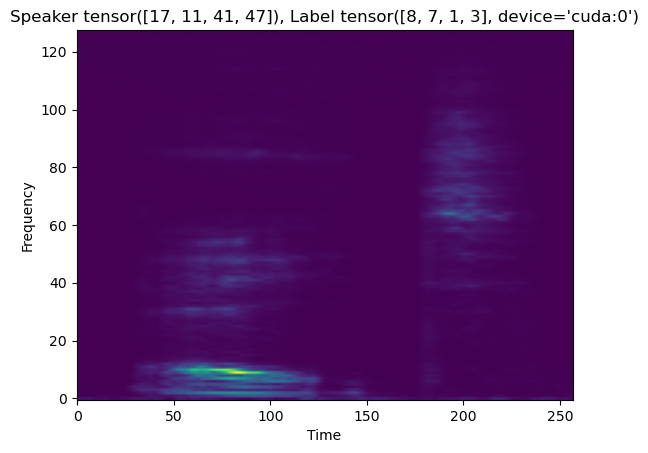

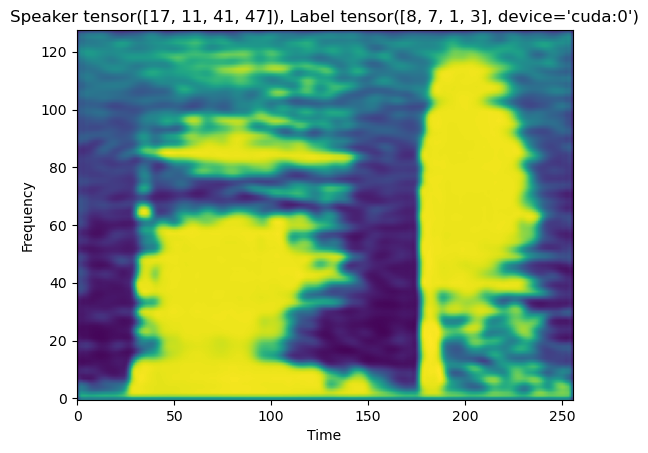

====> Test set loss: 3746.9351
Epoch 1:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 2614.354248  [    0/24000]
loss: 3304.595215  [  400/24000]
loss: 2966.128662  [  800/24000]
loss: 2541.460205  [ 1200/24000]
loss: 2355.771973  [ 1600/24000]
loss: 2850.581543  [ 2000/24000]
loss: 3128.346191  [ 2400/24000]
loss: 2901.893555  [ 2800/24000]
loss: 2692.235840  [ 3200/24000]
loss: 8656.798828  [ 3600/24000]
loss: 2620.556152  [ 4000/24000]
loss: 1830.214233  [ 4400/24000]
loss: 3342.715576  [ 4800/24000]
loss: 1994.567871  [ 5200/24000]
loss: 3225.401367  [ 5600/24000]
loss: 3169.374268  [ 6000/24000]
loss: 1607.138916  [ 6400/24000]
loss: 2402.571777  [ 6800/24000]
loss: 1889.256104  [ 7200/24000]
loss: 2065.845215  [ 7600/24000]
loss: 4932.574707  [ 8000/24000]
loss: 11905.044922  [ 8400/24000]
loss: 2784.557373  [ 8800/24000]
loss: 2236.277100  [ 9200/24000]
loss: 3523.172119  [ 9600/24000]
loss: 3285.924316  [10000/24000]
loss: 4555.530273  [10400/24000]
loss: 2744.631104  [10800/24000]
loss: 2632.219238  [11200/24000]
loss: 3609.252686  [11600/24000]
loss: 348

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

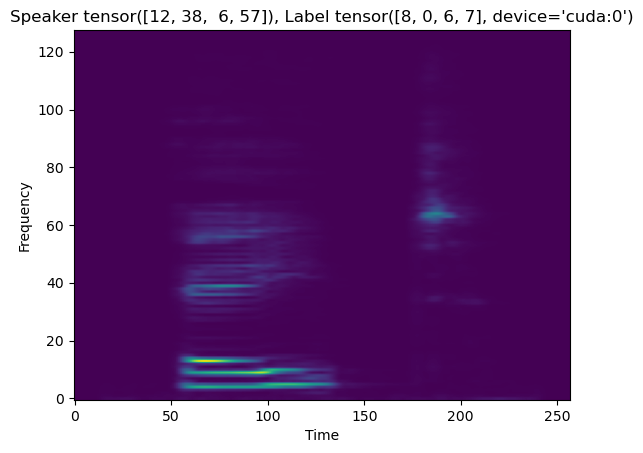

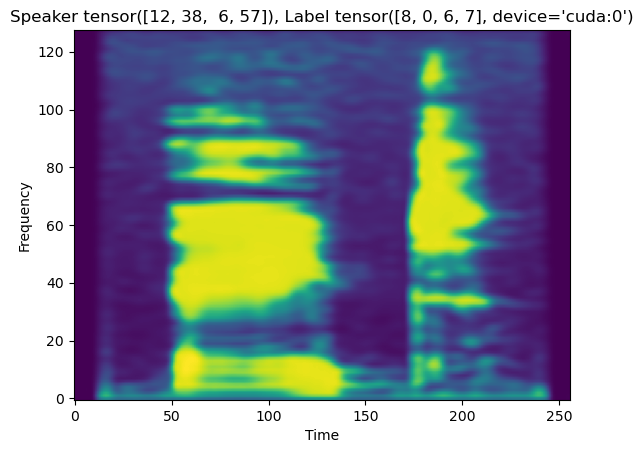

====> Test set loss: 3466.3196
Epoch 2:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 2374.693115  [    0/24000]
loss: 2536.443115  [  400/24000]
loss: 2622.130371  [  800/24000]
loss: 3694.563477  [ 1200/24000]
loss: 1849.730347  [ 1600/24000]
loss: 2955.135254  [ 2000/24000]
loss: 1655.045044  [ 2400/24000]
loss: 3253.844238  [ 2800/24000]
loss: 2509.971436  [ 3200/24000]
loss: 2197.839111  [ 3600/24000]
loss: 2724.386475  [ 4000/24000]
loss: 2528.458984  [ 4400/24000]
loss: 3156.637207  [ 4800/24000]
loss: 3259.204834  [ 5200/24000]
loss: 2176.324951  [ 5600/24000]
loss: 13723.839844  [ 6000/24000]
loss: 4037.248047  [ 6400/24000]
loss: 3158.238770  [ 6800/24000]
loss: 1837.488037  [ 7200/24000]
loss: 2429.151611  [ 7600/24000]
loss: 2040.036987  [ 8000/24000]
loss: 2761.475098  [ 8400/24000]
loss: 3209.615234  [ 8800/24000]
loss: 2306.722168  [ 9200/24000]
loss: 1540.857666  [ 9600/24000]
loss: 4804.645508  [10000/24000]
loss: 2666.460449  [10400/24000]
loss: 3106.190186  [10800/24000]
loss: 1980.590698  [11200/24000]
loss: 6929.852051  [11600/24000]
loss: 213

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

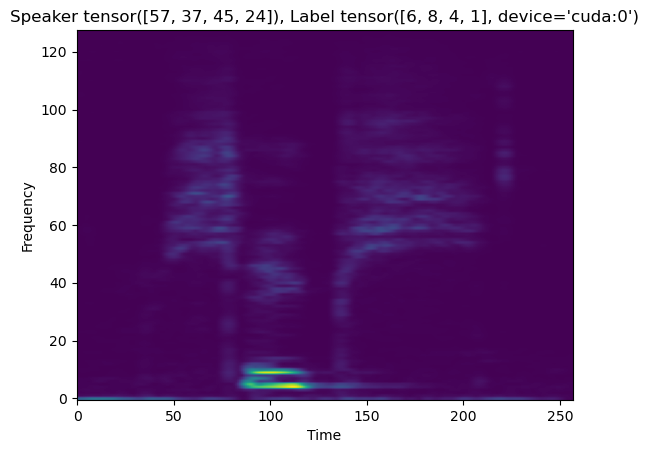

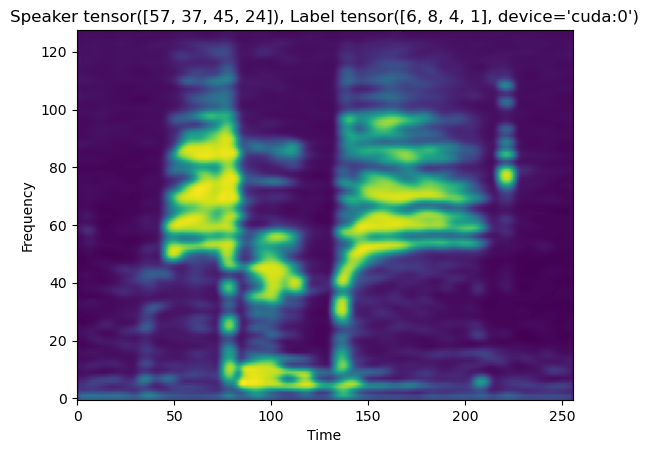

====> Test set loss: 3197.3677
Epoch 3:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 2729.440430  [    0/24000]
loss: 1773.019287  [  400/24000]
loss: 1755.202515  [  800/24000]
loss: 1210.681396  [ 1200/24000]
loss: 1748.244873  [ 1600/24000]
loss: 3120.247803  [ 2000/24000]
loss: 3808.568848  [ 2400/24000]
loss: 2844.574463  [ 2800/24000]
loss: 2357.754883  [ 3200/24000]
loss: 1625.854980  [ 3600/24000]
loss: 3365.062744  [ 4000/24000]
loss: 3658.727295  [ 4400/24000]
loss: 1131.706909  [ 4800/24000]
loss: 2163.573975  [ 5200/24000]
loss: 1963.241211  [ 5600/24000]
loss: 3025.712891  [ 6000/24000]
loss: 2750.455566  [ 6400/24000]
loss: 4580.943359  [ 6800/24000]
loss: 2712.362549  [ 7200/24000]
loss: 1860.735596  [ 7600/24000]
loss: 1338.147461  [ 8000/24000]
loss: 2319.213623  [ 8400/24000]
loss: 1545.043213  [ 8800/24000]
loss: 1815.944824  [ 9200/24000]
loss: 3384.132568  [ 9600/24000]
loss: 1424.453003  [10000/24000]
loss: 1598.583862  [10400/24000]
loss: 894.315857  [10800/24000]
loss: 2434.568848  [11200/24000]
loss: 2581.590088  [11600/24000]
loss: 3581.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

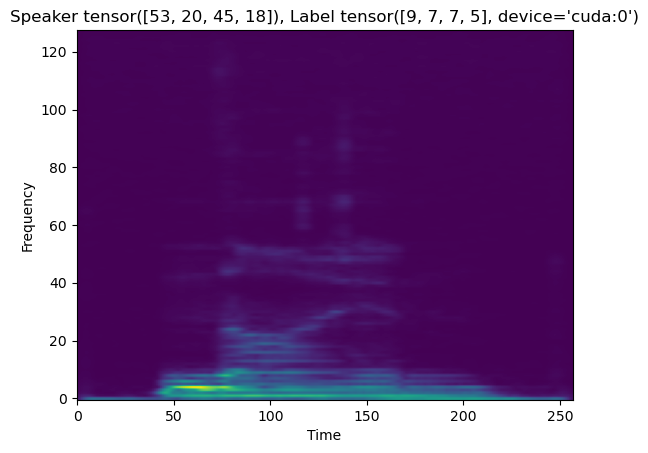

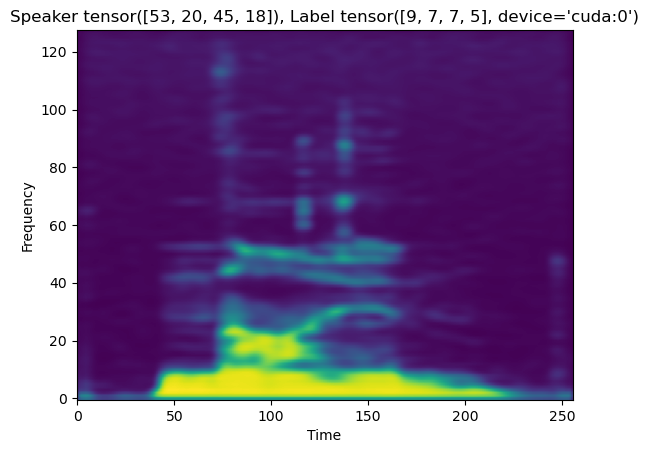

====> Test set loss: 2942.8999
Epoch 4:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csr

loss: 2415.792969  [    0/24000]
loss: 7504.384766  [  400/24000]
loss: 1813.592285  [  800/24000]
loss: 1545.453369  [ 1200/24000]
loss: 1463.734375  [ 1600/24000]
loss: 1990.541504  [ 2000/24000]
loss: 1213.767090  [ 2400/24000]
loss: 2866.078369  [ 2800/24000]
loss: 1907.805054  [ 3200/24000]
loss: 1962.853516  [ 3600/24000]
loss: 1715.929565  [ 4000/24000]
loss: 2666.354736  [ 4400/24000]
loss: 1844.190308  [ 4800/24000]
loss: 2219.558105  [ 5200/24000]
loss: 2299.685547  [ 5600/24000]
loss: 4256.999023  [ 6000/24000]
loss: 2812.547852  [ 6400/24000]
loss: 3327.538574  [ 6800/24000]
loss: 2133.805176  [ 7200/24000]
loss: 3740.349609  [ 7600/24000]
loss: 1906.180664  [ 8000/24000]
loss: 2583.555420  [ 8400/24000]
loss: 1705.107300  [ 8800/24000]
loss: 2212.425537  [ 9200/24000]
loss: 17239.927734  [ 9600/24000]
loss: 2860.091309  [10000/24000]
loss: 3973.045898  [10400/24000]
loss: 2560.145996  [10800/24000]


KeyboardInterrupt: 

In [30]:
MAX_ITERATIONS_WITHOUT_IMPROVEMENT = 10

# start training
start_time = time.time()
epoch = 0
iterations_without_improvement = 0
best_loss = float('inf')

while iterations_without_improvement < MAX_ITERATIONS_WITHOUT_IMPROVEMENT:
    print(f"Epoch {epoch}:")
    train_loss = train_step(dataloader_train, vae, optimizer)
    print(f"====> Epoch: {epoch} Training loss: {train_loss:.4f}")
    loss = test(dataloader_test, vae, f"{epoch}")
    print(f"====> Test set loss: {loss:.4f}")

    if loss < best_loss:
        best_loss = loss
        iterations_without_improvement = 0
        # save the model if it has improved
        torch.save(vae.state_dict(), f"model_{epoch}.pth")
    else:
        iterations_without_improvement += 1

    epoch += 1

time_took = time.time() - start_time
print(f"Training time: {time_took} seconds")
print(f"Epochs: {epoch}")

print("Done!")

# del variables on gpu and skip if one of them is not found
del_if_found(vae)
del_if_found(sample)
del_if_found(label)